# Set Up

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from google.colab import files

def load_grayscale_image(filename=None):
    """
    Loads an image from the Colab environment (if filename provided)
    or prompts user to upload, and converts to a grayscale NumPy array.
    """
    img_data = None

    if filename:
        try:
            with open(filename, 'rb') as f:
                img_data = f.read()
            print(f"Attempting to load '{filename}' directly from Colab filesystem.")
        except FileNotFoundError:
            print(f"File '{filename}' not found in Colab filesystem. Trying upload instead.")
            filename = None
        except Exception as e:
            print(f"Error reading '{filename}' directly: {e}. Trying upload instead.")
            filename = None

    if not filename:
        print("Please upload an image file.")
        uploaded = files.upload()

        if not uploaded:
            print("No file uploaded.")
            return None

        filename = next(iter(uploaded))
        img_data = uploaded[filename]

    if img_data:
        try:
            pil_image = Image.open(io.BytesIO(img_data)).convert('L')
            img_array = np.array(pil_image)
            print(f"Successfully loaded '{filename}' with shape {img_array.shape}")
            return img_array
        except Exception as e:
            print(f"Error processing image data for '{filename}': {e}")
            return None
    else:
        return None

def display_images(images, titles, colormap='gray', rows=1):
    """
    Displays a list of images in a grid.
    """
    n = len(images)
    cols = int(np.ceil(n / rows))

    plt.figure(figsize=(cols * 6, rows * 6))
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap=colormap)
        plt.title(titles[i], fontsize=14)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Segmentation using Otsu's Method

In [13]:
def get_histogram(image):
    """
    Calculates the histogram of a grayscale image (0-255).
    Returns a 256-element array where hist[i] is the count of pixels
    with intensity 'i'.
    """
    hist = np.zeros(256, dtype=int)
    for pixel_val in image.ravel():
        hist[pixel_val] += 1
    return hist

def otsu_thresholding(image):
    """
    Implements Otsu's thresholding method from scratch.
    Returns the optimal threshold value.
    """
    hist = get_histogram(image)
    total_pixels = image.size
    norm_hist = hist / (total_pixels + 1e-6)

    p1 = np.cumsum(norm_hist)
    m = np.cumsum(norm_hist * np.arange(0, 256))
    mg = m[255]

    epsilon = 1e-6
    p1[p1 == 0] = epsilon
    p1[p1 == 1] = 1 - epsilon

    w0 = p1
    w1 = 1 - w0

    mu0 = m / w0
    mu1 = (mg - m) / w1

    sigma_b_squared = w0 * w1 * (mu0 - mu1)**2

    optimal_threshold = np.argmax(sigma_b_squared)

    return optimal_threshold

def apply_threshold(image, threshold):
    """
    Applies a binary threshold to an image.
    Pixels > threshold become 255 (white).
    Pixels <= threshold become 0 (black).
    """
    binary_image = np.zeros_like(image, dtype=np.uint8)
    binary_image[image > threshold] = 255
    return binary_image

# Morphological Operation

In [14]:
def manual_pad(image, pad_width=1):
    """
    Manually pads an image with zeros.
    """
    h, w = image.shape
    padded_image = np.zeros((h + 2 * pad_width, w + 2 * pad_width), dtype=image.dtype)
    padded_image[pad_width:-pad_width, pad_width:-pad_width] = image
    return padded_image

def erosion(binary_image):
    """
    Performs erosion on a binary (0/255) image with a 3x3 square kernel.
    """
    h, w = binary_image.shape
    padded_image = manual_pad(binary_image, 1)
    eroded_image = np.zeros_like(binary_image)

    for i in range(h):
        for j in range(w):
            neighborhood = padded_image[i:i+3, j:j+3]
            if np.all(neighborhood == 255):
                eroded_image[i, j] = 255

    return eroded_image

def dilation(binary_image):
    """
    Performs dilation on a binary (0/255) image with a 3x3 square kernel.
    """
    h, w = binary_image.shape
    padded_image = manual_pad(binary_image, 1)
    dilated_image = np.zeros_like(binary_image)

    for i in range(h):
        for j in range(w):
            neighborhood = padded_image[i:i+3, j:j+3]
            if np.any(neighborhood == 255):
                dilated_image[i, j] = 255

    return dilated_image

def opening(binary_image):
    """
    Performs Opening: Erosion followed by Dilation.
    """
    eroded = erosion(binary_image)
    opened = dilation(eroded)
    return opened

def closing(binary_image):
    """
    Performs Closing: Dilation followed by Erosion.
    """
    dilated = dilation(binary_image)
    closed = erosion(dilated)
    return closed

# Main + Comparison

Attempting to load 'vibrant-plant-cells-stockcake.jpg' directly from Colab filesystem.
Successfully loaded 'vibrant-plant-cells-stockcake.jpg' with shape (408, 728)
Calculating optimal threshold using Otsu's method...
Optimal threshold found: 116
Applying morphological 'Closing' to clean the segmentation...

--- Comparison 1: Original vs. Raw vs. Closing ---


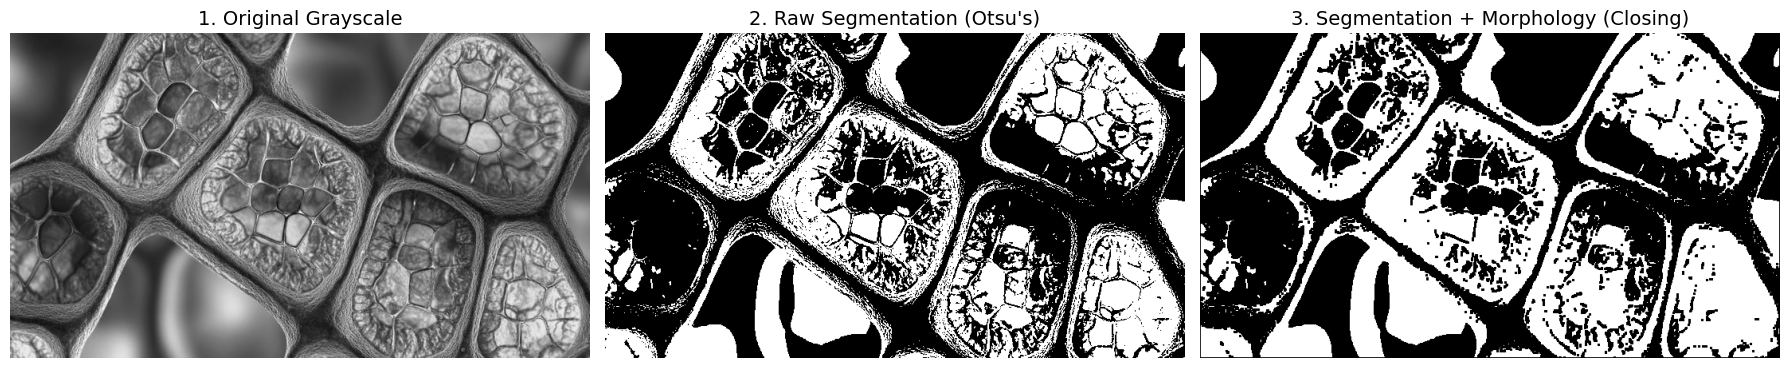


Applying 'Opening' to demonstrate the difference...

--- Comparison 2: Raw vs. Opening vs. Closing ---


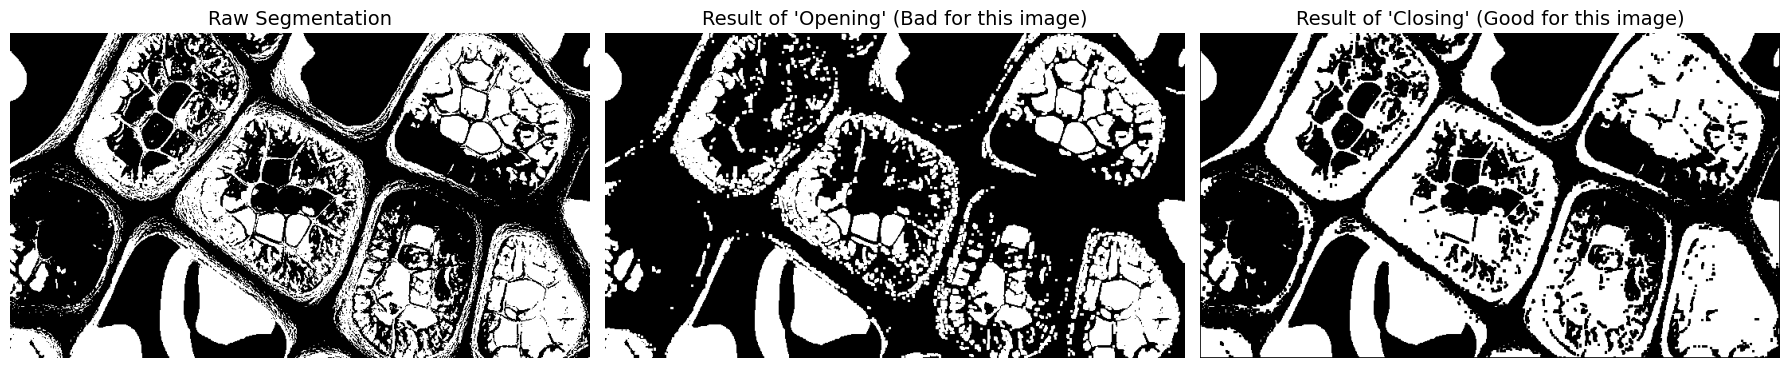

In [15]:
original_gray_image = load_grayscale_image(filename='vibrant-plant-cells-stockcake.jpg')

if original_gray_image is not None:

    print("Calculating optimal threshold using Otsu's method...")
    optimal_thresh = otsu_thresholding(original_gray_image)
    print(f"Optimal threshold found: {optimal_thresh}")

    segmented_image = apply_threshold(original_gray_image, optimal_thresh)

    if np.mean(segmented_image) > 128:
        print("Inverting segmentation to make foreground (walls) white for morphology...")
        segmented_image = 255 - segmented_image


    print("Applying morphological 'Closing' to clean the segmentation...")
    cleaned_image_closing = closing(segmented_image)

    print("\n--- Comparison 1: Original vs. Raw vs. Closing ---")
    display_images(
        images=[original_gray_image, segmented_image, cleaned_image_closing],
        titles=["1. Original Grayscale",
                "2. Raw Segmentation (Otsu's)",
                "3. Segmentation + Morphology (Closing)"]
    )

    print("\nApplying 'Opening' to demonstrate the difference...")
    cleaned_image_opening = opening(segmented_image)

    print("\n--- Comparison 2: Raw vs. Opening vs. Closing ---")
    display_images(
        images=[segmented_image, cleaned_image_opening, cleaned_image_closing],
        titles=["Raw Segmentation",
                "Result of 'Opening' (Bad for this image)",
                "Result of 'Closing' (Good for this image)"]
    )

else:
    print("\n--- IMAGE NOT LOADED ---")
    print("Could not load the image. Please make sure the file is uploaded and the filename is correct.")

# The Results

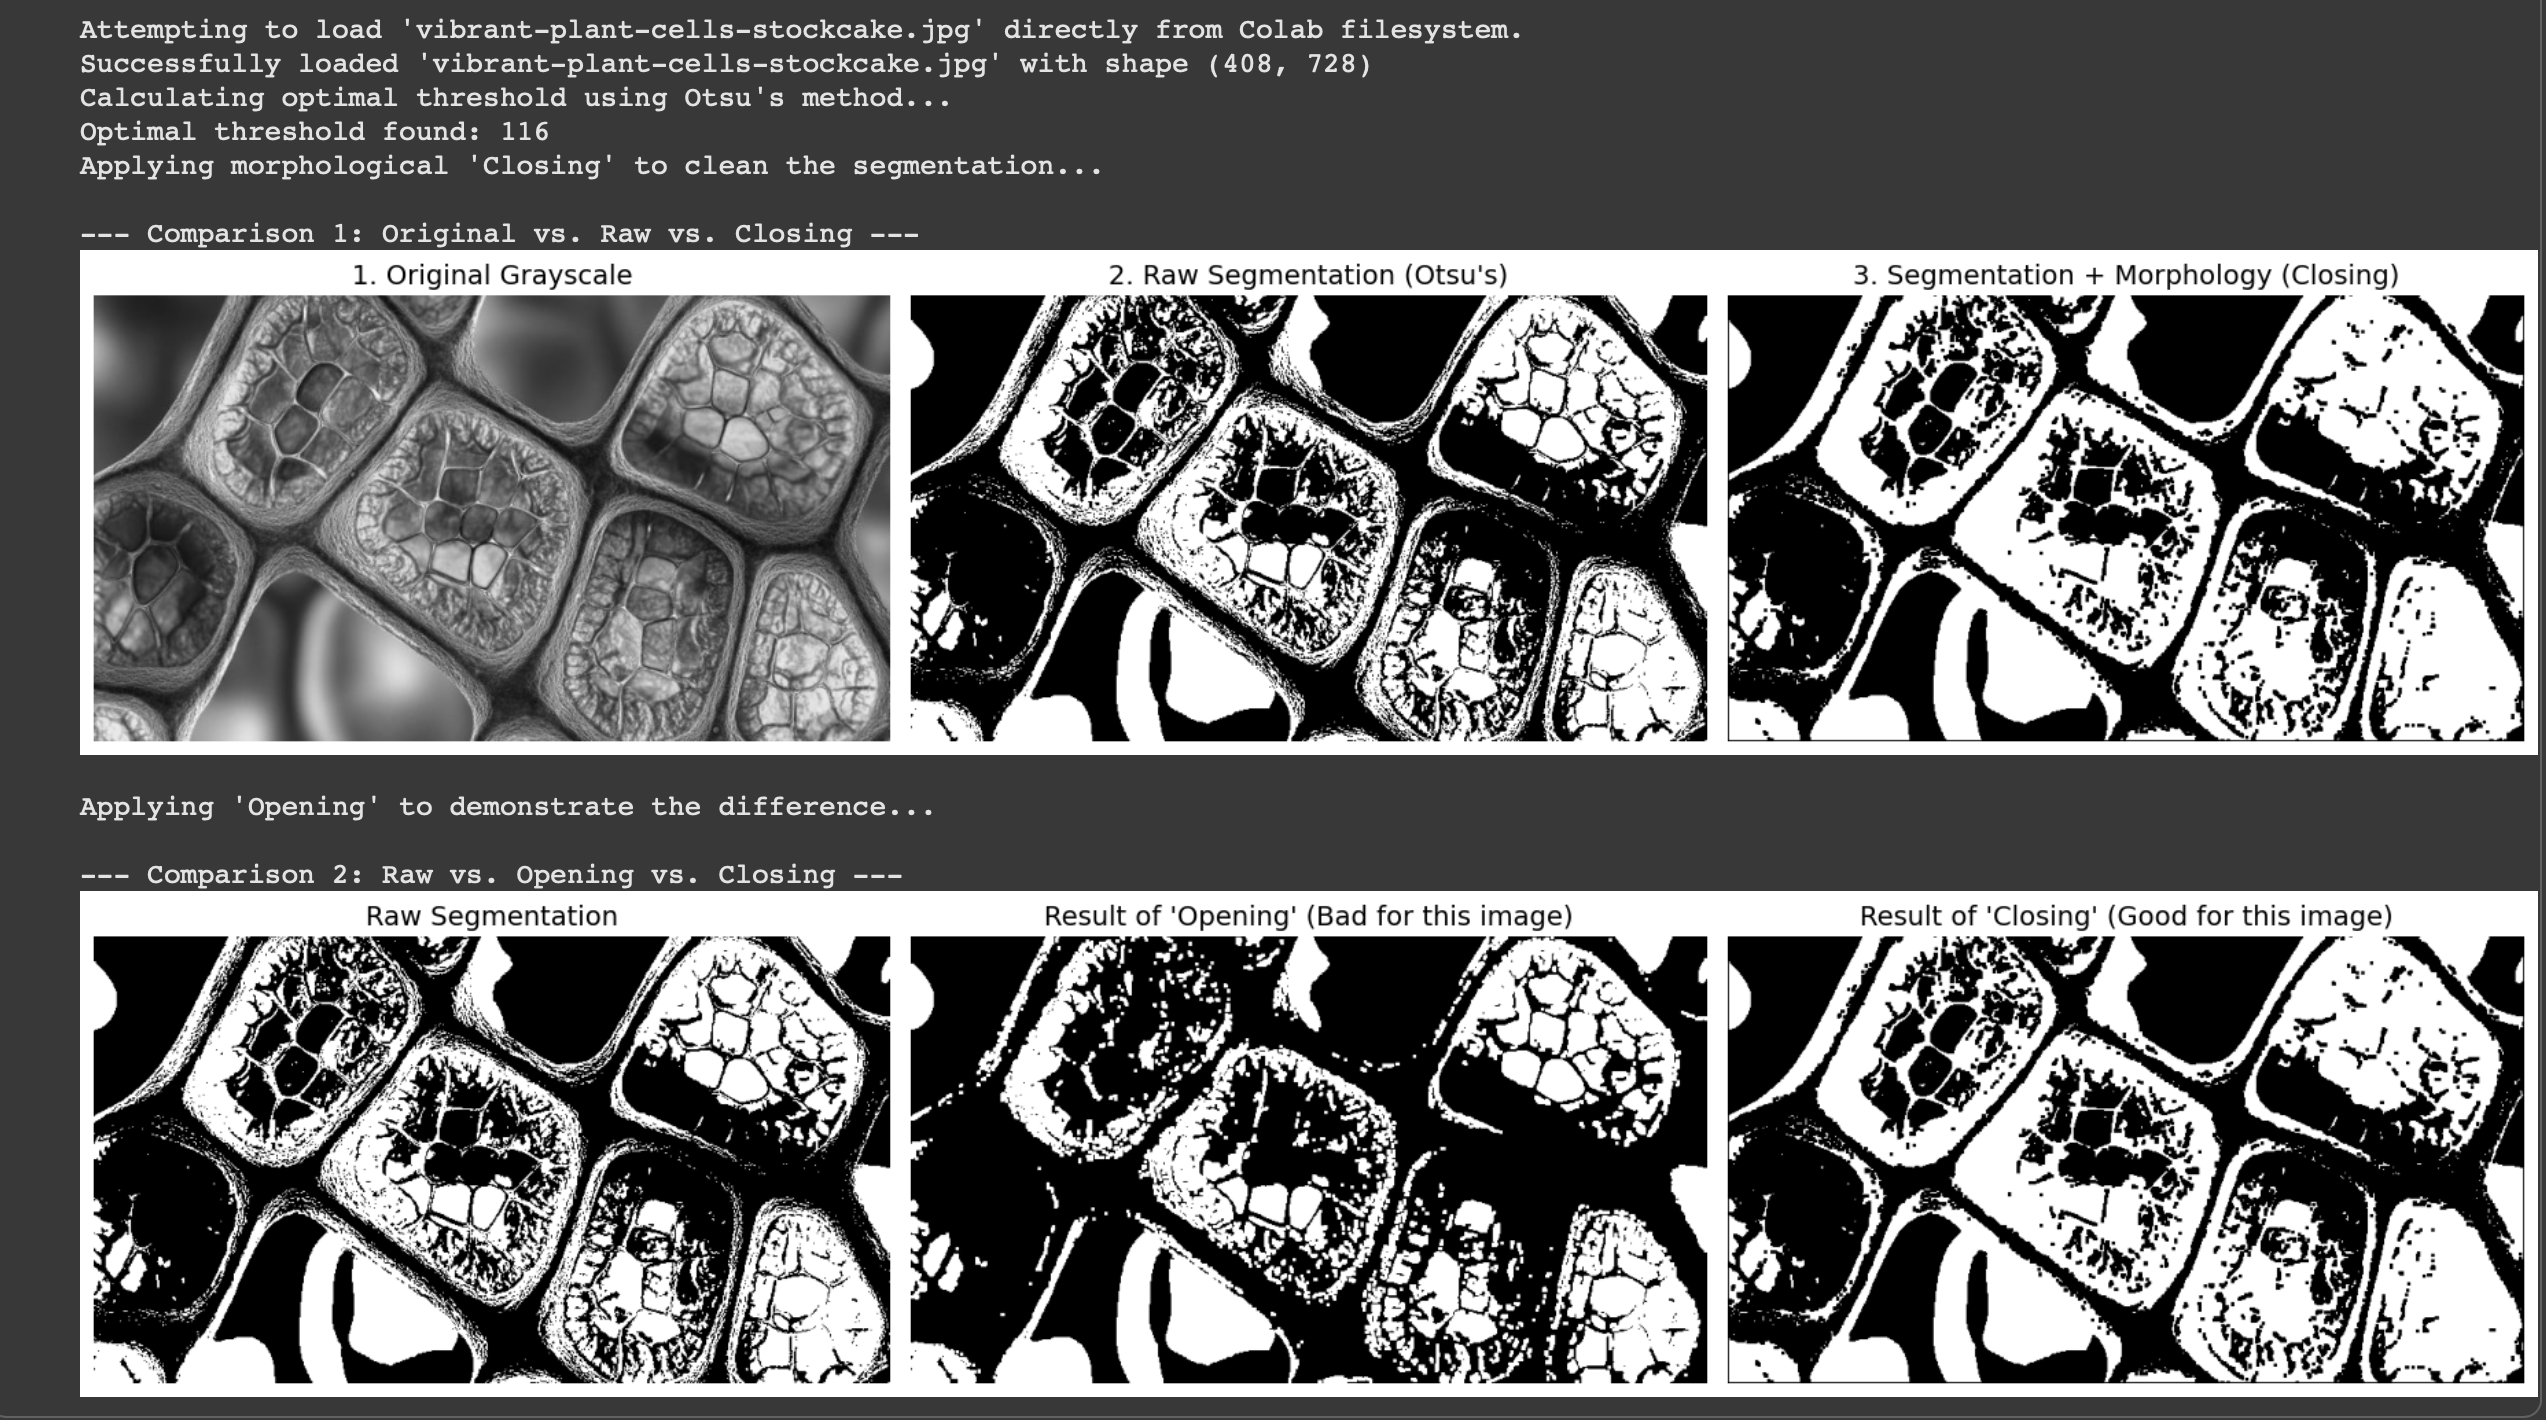